In [6]:
import sys
sys.path.append("../../src")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pickle
from example_pendulum import load_pendulum_data
from scipy.integrate import odeint
from autoencoder_pendulum import full_network
from training_pendulum import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [7]:
training_data, validation_data = load_pendulum_data()

x,dx,ddx = validation_data['x'], validation_data['dx'], validation_data['ddx']

data_test['x'].shape (5550, 7072)
data_test['dx'].shape (5550, 7072)
data_test['ddx'].shape (5550, 7072)


In [8]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
test_data['z'] = z[:,:,0].reshape((-1,params['latent_dim']))
test_data['dz'] = z[:,:,1].reshape((-1,params['latent_dim']))
test_data['ddz'] = dz[:,:,1].reshape((-1,params['latent_dim']))

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/marsgao/SindyAutoencoders/examples/pen_video/model1


In [10]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)
true_coefficients[-2] = -1.

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    pendulum_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

([], [])

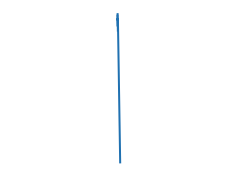

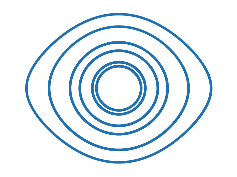

In [11]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,:,0].T, pendulum_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

(-49.95, 1048.95, -3.4640984535217285, -3.4531307220458984)

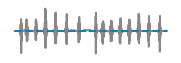

In [12]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

## Test set analysis - in distribution

In [9]:
test_data = get_pendulum_data(10)

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/marsgao/SindyAutoencoders/examples/pendulum/model4


In [11]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy reltive error, z: %f' % sindy_ddz_error)

Decoder relative error: 0.003462
Decoder relative SINDy error: 0.003556
SINDy reltive error, z: 0.044096


In [13]:
print(test_set_results['sindy_coefficients'])

[[ 5.2228199e-08]
 [-1.6447935e-08]
 [-3.4422655e+00]
 [ 8.3557357e-09]
 [ 3.6642561e+00]
 [-1.1336120e-08]
 [-5.7204609e-08]
 [-3.4406154e+00]
 [-2.0048612e-09]
 [-7.6008892e-01]
 [ 7.7742726e-08]
 [-6.1805019e+00]]


In [14]:
print(true_coefficients)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]]


In [19]:
import numpy as np
arr = np.load("save_1.npy")
arr_truncate = arr[0:-50]
arr_mean = np.mean(arr_truncate, axis=0)
print(arr_mean)

[[ 0.        ]
 [ 0.        ]
 [-1.81524709]
 [ 0.        ]
 [ 2.07543013]
 [ 0.        ]
 [ 0.        ]
 [-1.85309271]
 [ 0.        ]
 [-0.57890595]
 [ 0.        ]
 [-4.49665182]]
